In [1]:
import geopandas as gp
from shapely.geometry import Polygon
import sys
sys.path.append('..')

from utils.sa import place_labels
from matplotlib import pyplot as plt

countries_raw = gp.read_file("./tmp/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
populated_places_raw = gp.read_file('./tmp/ne_10m_populated_places_simple/ne_10m_populated_places_simple.shp')
routes_raw = gp.read_file('./data/trade-routes.geojson')

In [2]:
bounding_box = (-20,25,85,65)

countries = countries_raw.set_crs(epsg=4326)
populated_places = populated_places_raw.set_crs(epsg=4326)
routes = routes_raw.to_crs(4326)

map_extent = gp.GeoDataFrame(
    data={"geometry": [
        Polygon([
            (bounding_box[0], bounding_box[1]),
            (bounding_box[2], bounding_box[1]),
            (bounding_box[2], bounding_box[3]),
            (bounding_box[0], bounding_box[3]),
		])
	]},
    geometry="geometry",
    crs='EPSG:4326'
)

map_extent.to_file("./tmp/genoa-me.geojson")
routes.to_file("./tmp/genoa-trade-routes.geojson")

In [3]:
capitals = populated_places.loc[
    (populated_places["min_zoom"] < 4)
    & (populated_places["geometry"].x > bounding_box[0])
    & (populated_places["geometry"].x < bounding_box[2])
    & (populated_places["geometry"].y > bounding_box[1])
    & (populated_places["geometry"].y < bounding_box[3])
    ].copy()

label_points = place_labels(capitals, population_field="pop_max", time_limit=500)
label_points.to_file("./tmp/genoa-places.geojson")

step: 0/500 t: 10000000.0 e: 842


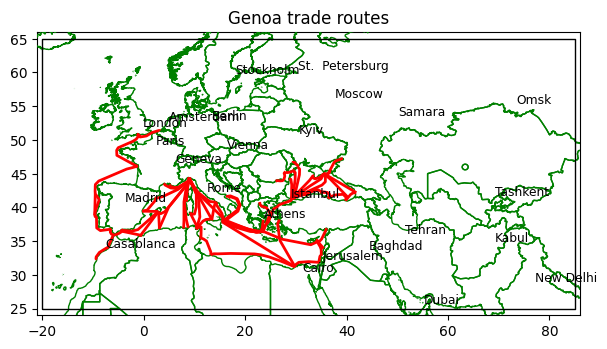

In [4]:
# Plot
fig, ax = plt.subplots(figsize=(7,6))
plt.title("Genoa trade routes")

ax.set_xlim(bounding_box[0] -1, bounding_box[2] + 1)
ax.set_ylim(bounding_box[1] -1, bounding_box[3] + 1)

countries.plot(ax=ax, color="none", edgecolor="green", zorder=10)
map_extent.plot(ax=ax, color='none', edgecolor="black", lw=1, zorder=100)
routes.plot(ax=ax, color="red", edgecolor="blue", lw=2, zorder=200)

for i, l in label_points.iterrows():
	plt.text(
        l.geometry.x,
        l.geometry.y,
        f"{l.label_text}",
        fontsize=l.font_size * 4.75,
        horizontalalignment=l.text_align_horizontal,
        verticalalignment="bottom",
		zorder=200
    )